# Compare barometric pressure recorded by analog barometers and vibrating wire sensors
Here we use the 4-hourly summary data.
* Analog barometers are temperature-corrected, so can be considered a direct measure of true barometric pressure. However, the still need correcting to a height of 0 feet.
* Vibrating wire sensors need to be corrected with the corresponding temperature data, and height corrected to 0 feet.

## 1. Set up and Load transducers metadata

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import datetime as dt
import header
paths = header.setup_environment()
import platform
if platform.system()=='Darwin':
    INPUTDIR = '/Users/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/MERGED'
else:
    INPUTDIR = os.path.join(paths['new_data'], '03_merge_inventories')
import libWellData as LLE
transducersDF = LLE.get_transducers_dataframe(paths)
display(transducersDF)

# set standard temperature and pressure
std_temperature = 20.0
std_passcals = 101325
pa2psi = 0.000145038
std_psi = std_passcals * pa2psi


/var/folders/4q/5426zn1d72vgcb6h658n_8800000gn/T/ipykernel_54640/1454665653.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Darwin


,serial,Fs,sensor,shielding,range_kPa_low,range_kPa_high,media,type,model,set_depth_ft,id,well,dig0,gf,tt,tt0,tf,bp,bp0
0,AirPressureShallow,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.81,6S.02374.88.HDH,shallow,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1226420,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.46,6S.12264.20.HDD,shallow,9751.0,-0.006458,21.6,21.3,-0.008795,0.000,14.298
2,1226423,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-5.83,6S.12264.23.BDD,shallow,9605.0,-0.006347,21.6,22.2,-0.004197,14.504,14.298
3,1226419,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-6.71,6S.12264.19.HDD,shallow,10040.0,-0.006441,21.6,21.1,-0.010870,14.504,14.298
4,1226421,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-7.71,6S.12264.21.HDD,shallow,9787.0,-0.006724,21.6,21.3,-0.001145,14.504,14.298
5,AirPressureDeep,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.86,6I.0XXXX.XX.HDH,intermediate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1226429,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.11,6I.12264.29.HDD,intermediate,9800.0,-0.006428,22.6,21.6,-0.002384,0.000,14.298
7,2151692,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-9.14,6I.21516.92.BDD,intermediate,9459.0,-0.008038,22.8,21.8,0.007666,14.296,14.388
8,2151691,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-18.31,6I.21516.91.HDD,intermediate,9414.0,-0.008142,22.8,21.5,0.008742,14.296,14.388
9,2149882,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-19.14,6I.21498.82.HDD,intermediate,9734.0,-0.008075,20.7,21.3,0.000675,14.602,14.389


# 2. Subset the summary of all files dataframe by Baro, 20 Hz, and 100 Hz subdirectories
Display the columns of each, after dropping empty columns.
* Baro only contains data columns for AirPressureShallow and AirPressureDeep.
* 20 Hz contains data columns for 1226423 and 2151692, plus corresponding temperature and stdev data
* 100 Hz contains data columns for '1226421', '1226419', '1226420', '2149882','2151691', and '1226429', plus corresponding temperature and stdev data

We plot:
- the barometric data
- the 100 Hz temperature data

Since none of these needs to be corrected (although later we will adjust barometric data to a height of 0 feet)

In [3]:
# Load in the summary of all files - raw 4 hourly data 
dfall2 = pd.read_csv(os.path.join(INPUTDIR, 'all2.csv'))

# Split in baro, 20Hz, 100Hz
dfbaro = dfall2.copy()[dfall2['subdir']=="Baro"]
dfbaro['datetime'] = pd.to_datetime(dfbaro['TIMESTAMP'])
dfbaro.dropna(how='all', axis=1, inplace=True) 
dfbaro.drop(dfbaro.columns[dfbaro.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

df20hz = dfall2.copy()[dfall2['subdir']=="20hz"]
df20hz['datetime'] = pd.to_datetime(df20hz['TIMESTAMP'])
df20hz.dropna(how='all', axis=1, inplace=True) 
df20hz.drop(df20hz.columns[df20hz.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

df100hz = dfall2.copy()[dfall2['subdir']=="100hz"]
df100hz['datetime'] = pd.to_datetime(df100hz['TIMESTAMP'])
df100hz.dropna(how='all', axis=1, inplace=True) 
df100hz.drop(df100hz.columns[df100hz.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)




## 3. Examine thermometer data 
For each vibrating wire pressure transducer, there is a corresponding thermal record
Find these columns and rename them to match the transducer serial number + "_temp"

Therm(1) -> 1226421_temp
Therm(2) -> 1226419_temp
Therm(3) -> 1226420_temp
Therm(4) -> 2149882_temp
Therm(5) -> 2151691_temp
Therm(6) -> 1226429_temp


<Axes: xlabel='depth', ylabel='stdev(Temperature), C '>

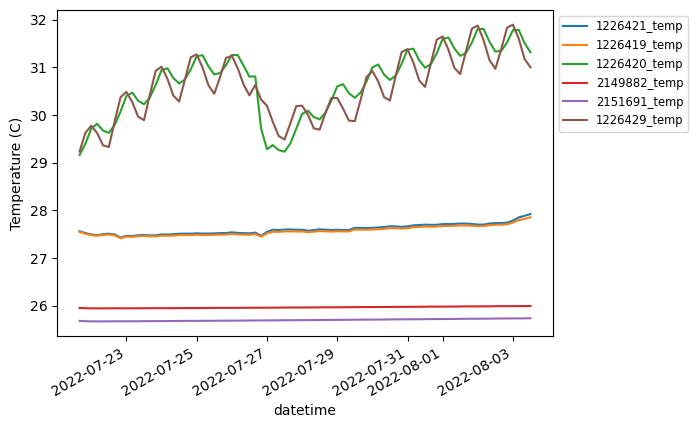

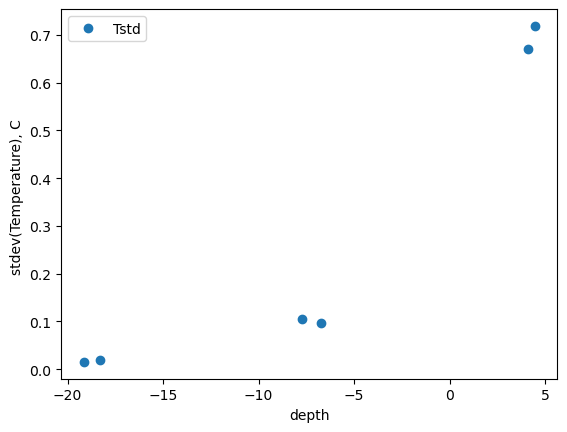

In [12]:
# subset to all rows that have a 'Therm(6)' column
df100hz_thermal = df100hz.copy().dropna(subset=['Therm(6)'])
#display(df100hz_thermal)
count = 0 
lod = []
for col in df100hz_thermal:
    if isinstance(col,str) and (col[0:2]=='12' or col[0:2]=='21'):
        count += 1
        oldcol = f'Therm({count})'
        newcol = f'{col}_temp'
        print(oldcol,'->',newcol)
        df100hz_thermal.rename(columns={oldcol:newcol}, inplace=True)
        this_transducer = get_transducer_metadata(col, transducersDF)
        depth = this_transducer['set_depth_ft']
        lod.append({'depth':depth, 'Tstd':df100hz_thermal[newcol].std()})
thermal_columns = [item for item in df100hz_thermal.columns if item.endswith('_temp')]
df100hz_thermal.plot(x='datetime', y=thermal_columns, kind='line', ylabel='Temperature (C)').legend(bbox_to_anchor=(1.0,1.0), fontsize='small')
dftemp = pd.DataFrame(lod)
dftemp.plot(x='depth', y='Tstd', style='o', ylabel='stdev(Temperature), C ')

## 3. Plot raw barometric data


<Axes: xlabel='datetime'>

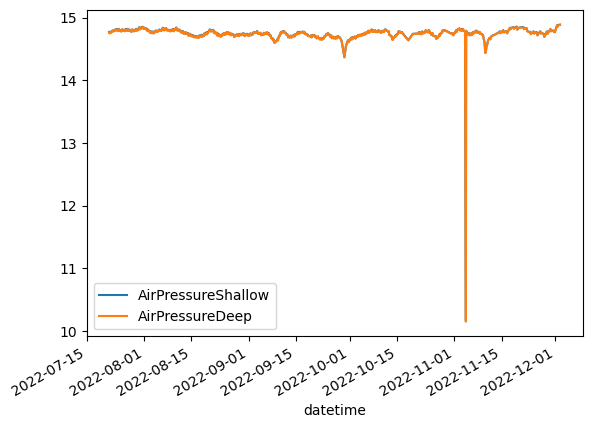

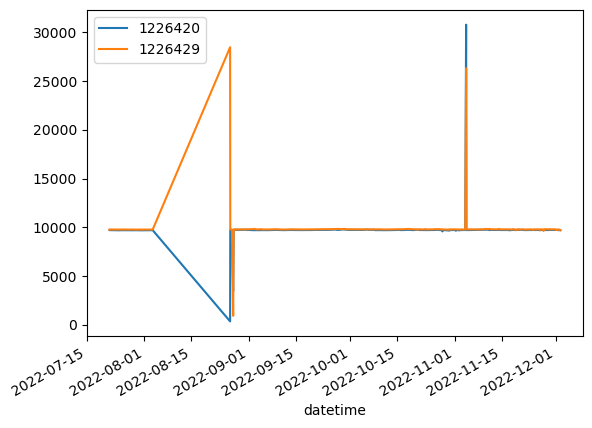

In [4]:
dfbaro.plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
df100hz.plot(x='datetime', y=['1226420', '1226429'], kind='line')

## 4. Correct all barometers and vibrating wire sensor data
- barometers are corrected for height only
- vibrating wire sensors in air are corrected for height also
- all vibrating wire sensors are corrected for sensitivity, and temperature
- vibrating wire sensors in water are corrected for barometric pressure too, from vibrating wire sensor in air

<Axes: xlabel='datetime'>

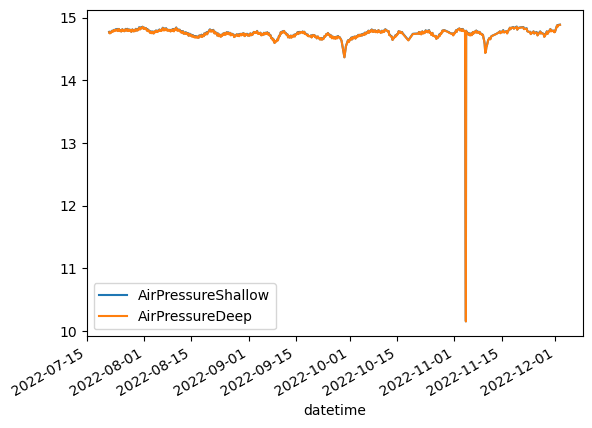

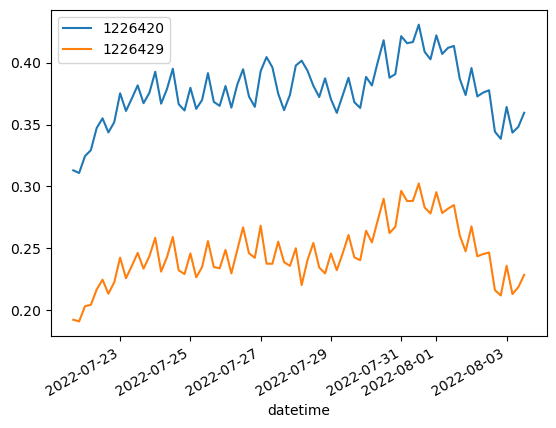

In [7]:
def PaDiff1m(T=std_temperature):
    PaPerM = 12.67 - 0.041*T
    return PaPerM

def correctForHeightAboveWaterFt(heightFt=0, T=std_temperature):
    heightM = heightFt * 0.3048
    psi_shift = (PaDiff1m(T=T) * heightM) * pa2psi
    return psi_shift

def correctForDepthBelowWaterFt(depthFt=0, T=std_temperature):
    # correct up to 0m
    psi_shift = depthFt/2.31
    return psi_shift

def correctVibratingWireDigits(rawSeries, this_transducer, temperatureSeries=None, airpressureSeries=None, depthCorrect=False):
    # correct for gain
    a = (rawSeries - this_transducer['dig0']) * this_transducer['gf']
    # correct for temperature
    if isinstance(temperatureSeries,pd.Series):
        a += (temperatureSeries - this_transducer['tt0']) * this_transducer['tf']
    # correct for air pressure
    if isinstance(airpressureSeries,pd.Series):
        a -= (airpressureSeries - this_transducer['bp0'])
    # correct for depth back to water surface
    if depthCorrect:
        psiShift = correctForDepthBelowWaterFt(depthFt=-this_transducer['set_depth_ft'])
        barometricDF[col] = barometricDF[col] - psiShift
    return a   

def get_transducer_metadata(serialnum, transducersDF):
    this_transducer = None
    subsetdf = transducersDF[(transducersDF['serial']) == serialnum]
    if len(subsetdf.index)==1:
        this_transducer = subsetdf.iloc[0].to_dict()    
    return this_transducer


def correctBarometricData(rawdf, barometricColumns, transducersDF, temperatureCorrect=True, heightCorrect=True):
    # turn barometric columns from digits into PSI
    barometricDF = rawdf.copy()
    for col in barometricColumns:
        if col in barometricDF:
            this_transducer = get_transducer_metadata(col, transducersDF)
            if isinstance(col,str) and (col=='1226420' or col=='1226429'):
                   
                # get temperature series
                tempcol = f'{col}_temp'
                temperatureSeries=None
                if tempcol in barometricDF.columns:
                    temperatureSeries = barometricDF[tempcol]

                barometricDF[col] = correctVibratingWireDigits(barometricDF[col], this_transducer, \
                                                              temperatureSeries=temperatureSeries, \
                                                                airpressureSeries=None, \
                                                                    depthCorrect=False)        

            # do height correction - we do this for analog barometers too
            if heightCorrect:
                psiShift = correctForHeightAboveWaterFt(heightFt=this_transducer['set_depth_ft'])
                barometricDF[col] = barometricDF[col] + psiShift

    return barometricDF

def rawdf2psidf(barometricdf, transducersDF, temperatureCorrect=True, airpressureCorrect=True, depthCorrect=False):
    psidf = barometricdf.copy()
    #print('- Applying calibration equations')
    for col in psidf.columns:
        if isinstance(col,str) and (col[0:2]=='12' or col[0:2]=='21'):
            if isinstance(col,str) and (col=='1226420' or col=='1226429'):
                continue # we should already have corrected these to sea level PSI
            this_transducer = get_transducer_metadata(col, transducersDF)
            if this_transducer:

                # get temperature series
                tempcol = f'{col}_temp'
                temperatureSeries=None
                if tempcol in psidf.columns:
                    temperatureSeries = psidf[tempcol]

                # get airpressure series
                airpressureSeries = None
                if airpressureCorrect:
                    if this_transducer['well']=='shallow':
                        airpressureSeries = psidf['1226420']
                    elif this_transducer['well']=='intermediate':
                        airpressureSeries = psidf['1226429']

                psidf[col] = correctVibratingWireDigits(psidf[col], this_transducer, \
                                                              temperatureSeries=temperatureSeries, \
                                                                airpressureSeries=airpressureSeries, \
                                                                    depthCorrect=depthCorrect)
    return psidf


def psidf2passcalsdf():
    # convert every PSI column to Pa
    pass

dfbaro_elevationRemoved_PSI = correctBarometricData(dfbaro, ['AirPressureShallow','AirPressureDeep'], transducersDF, temperatureCorrect=False, heightCorrect=True)  
dfbaro_elevationRemoved_PSI.plot(x='datetime', y=['AirPressureShallow', 'AirPressureDeep'], kind='line')
df100hz_elevationRemoved_aircolumnonly = correctBarometricData(df100hz_thermal, ['1226420', '1226429'], transducersDF, temperatureCorrect=True, heightCorrect=True)
df100hz_elevationRemoved_PSI = rawdf2psidf(df100hz_elevationRemoved_aircolumnonly, transducersDF, temperatureCorrect=True, airpressureCorrect=True, depthCorrect=False)
df100hz_elevationRemoved_PSI.plot(x='datetime', y=['1226420', '1226429'], kind='line')

## 5. Merge the dataframes after rounding timestamps to nearest hour 
All time series from the all2.csv are 4-hourly since we have only 1 file per 4 hours. So we can round to the nearest hour to align times that are generally within 1-s

Drop columns we do not need

In [6]:
df100hz_elevationRemoved_PSI ['nearesthour'] = df100hz_elevationRemoved_PSI ['datetime'].dt.round('H')
dfbaro_elevationRemoved_PSI['nearesthour'] = dfbaro_elevationRemoved_PSI['datetime'].dt.round('H')
dfmerged = pd.merge(df100hz_elevationRemoved_PSI , dfbaro_elevationRemoved_PSI, on='nearesthour')
dfmerged = dfmerged.loc[:, ~dfmerged.columns.str.endswith('_x')]
dfmerged = dfmerged.loc[:, ~dfmerged.columns.str.endswith('_y')]
dfmerged = dfmerged.loc[:, ~dfmerged.columns.str.startswith('DynStdDev')]
display(dfmerged)


/var/folders/4q/5426zn1d72vgcb6h658n_8800000gn/T/ipykernel_42755/3692021864.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df100hz_elevationRemoved_PSI ['nearesthour'] = df100hz_elevationRemoved_PSI ['datetime'].dt.round('H')
/var/folders/4q/5426zn1d72vgcb6h658n_8800000gn/T/ipykernel_42755/3692021864.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dfbaro_elevationRemoved_PSI['nearesthour'] = dfbaro_elevationRemoved_PSI['datetime'].dt.round('H')


,1226421,1226419,1226420,2149882,2151691,1226429,1226421_temp,1226419_temp,1226420_temp,2149882_temp,2151691_temp,1226429_temp,nearesthour,AirPressureShallow,AirPressureDeep
0,18.213446,17.527963,0.243783,23.152858,22.848474,0.173795,27.561035,27.545471,29.161621,25.950348,25.679871,29.232971,2022-07-21 16:00:00,14.756270,14.754263
1,18.220605,17.536305,0.239559,23.158818,22.853999,0.171514,27.521179,27.505676,29.397339,25.944275,25.670624,29.626465,2022-07-21 20:00:00,14.756245,14.750791
2,18.221145,17.535444,0.250424,23.157443,22.852237,0.183415,27.492371,27.479401,29.714417,25.941925,25.667999,29.774445,2022-07-22 00:00:00,14.761181,14.760819
3,18.216861,17.530021,0.254347,23.153954,22.848848,0.184940,27.476013,27.464600,29.814117,25.941284,25.667755,29.621674,2022-07-22 04:00:00,14.767820,14.761923
4,18.188574,17.502009,0.273572,23.130388,22.824695,0.197947,27.499451,27.482025,29.671875,25.940979,25.667847,29.363586,2022-07-22 08:00:00,14.787139,14.783863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,17.976666,17.281835,0.248564,22.884486,22.570603,0.187231,27.740326,27.705566,31.520721,25.987427,25.729462,31.831207,2022-08-02 20:00:00,14.760688,14.755793
74,17.947809,17.252300,0.272073,22.851748,22.537731,0.211113,27.783051,27.741486,31.780548,25.988190,25.729797,31.895569,2022-08-03 00:00:00,14.783177,14.777153
75,17.908050,17.211806,0.251231,22.809397,22.495392,0.188904,27.851074,27.794891,31.785370,25.988678,25.730652,31.600433,2022-08-03 04:00:00,14.761443,14.753369
76,17.883811,17.187464,0.258380,22.783550,22.469809,0.195550,27.883545,27.820007,31.507477,25.989471,25.731873,31.174622,2022-08-03 08:00:00,14.769860,14.763113


## 6. Correlate the air pressure columns - and compare their means too


In [12]:
cols = ['AirPressureShallow', 'AirPressureDeep', '1226420', '1226429']
xcorr = np.ndarray(shape=(4,4), dtype=float)
dcshift = np.ndarray(shape=(4,4), dtype=float)
for i1,col1 in enumerate(cols):
    #display(col1, dfmerged[col1].describe())
    for i2,col2 in enumerate(cols):
        xcorr[i1,i2] = pd.Series.corr(dfmerged[col1], dfmerged[col2])
        dcshift[i1,i2] = dfmerged[col1].mean()-dfmerged[col2].mean()
display(xcorr)
display(dcshift)

array([[1.        , 0.99307642, 0.864787  , 0.97519868],
       [0.99307642, 1.        , 0.87265763, 0.97497606],
       [0.864787  , 0.87265763, 1.        , 0.8712749 ],
       [0.97519868, 0.97497606, 0.8712749 , 1.        ]])

array([[ 0.00000000e+00,  4.29747292e-03,  1.45080403e+01,
         1.45788963e+01],
       [-4.29747292e-03,  0.00000000e+00,  1.45037429e+01,
         1.45745988e+01],
       [-1.45080403e+01, -1.45037429e+01,  0.00000000e+00,
         7.08559220e-02],
       [-1.45788963e+01, -1.45745988e+01, -7.08559220e-02,
         0.00000000e+00]])

## 7. Repeat the analysis, but don't make a temperature correction


In [13]:
df100hz_elevationRemoved_aircolumnonly_noT = correctBarometricData(df100hz_thermal, ['1226420', '1226429'], transducersDF, temperatureCorrect=False, heightCorrect=True)
df100hz_elevationRemoved_aircolumnonly_noT['nearesthour'] = df100hz_elevationRemoved_aircolumnonly_noT['datetime'].dt.round('H')
dfmerged2 = pd.merge(df100hz_elevationRemoved_aircolumnonly_noT , dfbaro_elevationRemoved_PSI, on='nearesthour')
dfmerged2 = dfmerged2.loc[:, ~dfmerged2.columns.str.endswith('_x')]
dfmerged2 = dfmerged2.loc[:, ~dfmerged2.columns.str.endswith('_y')]
dfmerged2 = dfmerged2.loc[:, ~dfmerged2.columns.str.startswith('DynStdDev')]
cols = ['AirPressureShallow', 'AirPressureDeep', '1226420', '1226429']
xcorr = np.ndarray(shape=(4,4), dtype=float)
dcshift = np.ndarray(shape=(4,4), dtype=float)
for i1,col1 in enumerate(cols):
    #display(col1, dfmerged2[col1].describe())
    for i2,col2 in enumerate(cols):
        xcorr[i1,i2] = pd.Series.corr(dfmerged2[col1], dfmerged2[col2])
        dcshift[i1,i2] = dfmerged2[col1].mean()-dfmerged2[col2].mean()
display(xcorr)
display(dcshift)

/var/folders/4q/5426zn1d72vgcb6h658n_8800000gn/T/ipykernel_42755/2830506114.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df100hz_elevationRemoved_aircolumnonly_noT['nearesthour'] = df100hz_elevationRemoved_aircolumnonly_noT['datetime'].dt.round('H')


array([[1.        , 0.99307642, 0.864787  , 0.97519868],
       [0.99307642, 1.        , 0.87265763, 0.97497606],
       [0.864787  , 0.87265763, 1.        , 0.8712749 ],
       [0.97519868, 0.97497606, 0.8712749 , 1.        ]])

array([[ 0.00000000e+00,  4.29747292e-03,  1.45080403e+01,
         1.45788963e+01],
       [-4.29747292e-03,  0.00000000e+00,  1.45037429e+01,
         1.45745988e+01],
       [-1.45080403e+01, -1.45037429e+01,  0.00000000e+00,
         7.08559220e-02],
       [-1.45788963e+01, -1.45745988e+01, -7.08559220e-02,
         0.00000000e+00]])